<a href="https://colab.research.google.com/github/mrreyesm/NLP_tweets/blob/main/NLP_tweets_on_war.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [41]:
# For sending GET requests from the API
import requests
# For saving access tokens and for file management when creating and adding to the dataset
import os
# For dealing with json responses we receive from the API
import json
# For displaying the data after
import pandas as pd
# For saving the response data in CSV format
import csv
# For parsing the dates received from twitter in readable formats
import datetime
import dateutil.parser
import unicodedata
#To add wait time between requests
import time
# For natural language processing
import nltk
nltk.download('punkt')
from nltk import word_tokenize
# For string manipulation
import string
# To create a word cloud with tweets
from wordcloud import WordCloud
#To visualize
import matplotlib.pyplot as plt

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [15]:
os.environ['TOKEN'] = ''

In [16]:
def auth():
    return os.getenv('TOKEN')

In [17]:
def create_headers(bearer_token):
    headers = {"Authorization": "Bearer {}".format(bearer_token)}
    return headers

In [19]:
def create_url(keyword, start_date, end_date, max_results = 10):
    
    search_url = "https://api.twitter.com/2/tweets/search/recent" #Change to the endpoint you want to collect data from

    #change params based on the endpoint you are using
    query_params = {'query': keyword,
                    'start_time': start_date,
                    'end_time': end_date,
                    'max_results': max_results,
                    'expansions': 'author_id,in_reply_to_user_id,geo.place_id',
                    'tweet.fields': 'id,text,author_id,in_reply_to_user_id,geo,conversation_id,created_at,lang,public_metrics,referenced_tweets,reply_settings,source',
                    'user.fields': 'id,name,username,created_at,description,public_metrics,verified',
                    'place.fields': 'full_name,id,country,country_code,geo,name,place_type',
                    'next_token': {}}
    return (search_url, query_params)

In [20]:
def connect_to_endpoint(url, headers, params, next_token = None):
    params['next_token'] = next_token   #params object received from create_url function
    response = requests.request("GET", url, headers = headers, params = params)
    print("Endpoint Response Code: " + str(response.status_code))
    if response.status_code != 200:
        raise Exception(response.status_code, response.text)
    return response.json()

In [29]:
def append_to_csv(json_response, fileName):

    #A counter variable
    counter = 0

    #Open OR create the target CSV file
    csvFile = open(fileName, "a", newline="", encoding='utf-8')
    csvWriter = csv.writer(csvFile)

    #Loop through each tweet
    for tweet in json_response['data']:
        
        # We will create a variable for each since some of the keys might not exist for some tweets
        # So we will account for that

        # 1. Author ID
        author_id = tweet['author_id']

        # 2. Time created
        created_at = dateutil.parser.parse(tweet['created_at'])

        # 3. Geolocation
        if ('geo' in tweet):   
            geo = tweet['geo']['place_id']
        else:
            geo = " "

        # 4. Tweet ID
        tweet_id = tweet['id']

        # 5. Language
        lang = tweet['lang']

        # 6. Tweet metrics
        retweet_count = tweet['public_metrics']['retweet_count']
        reply_count = tweet['public_metrics']['reply_count']
        like_count = tweet['public_metrics']['like_count']
        quote_count = tweet['public_metrics']['quote_count']

        # 7. source
        source = tweet['source']

        # 8. Tweet text
        text = tweet['text']
        
        # Assemble all data in a list
        res = [author_id, created_at, geo, tweet_id, lang, like_count, quote_count, reply_count, retweet_count, source, text]
        
        # Append the result to the CSV file
        csvWriter.writerow(res)
        counter += 1

    # When done, close the CSV file
    csvFile.close()

    # Print the number of tweets for this iteration
    print("# of Tweets added from this response: ", counter) 

In [34]:
#Inputs for the request
bearer_token = auth()
headers = create_headers(bearer_token)
keyword = "Ukraine lang:en"
start_time = "2022-02-25T00:00:00.000Z"
end_time = "2022-03-02T00:00:00.000Z"
max_results = 100

In [35]:
#Checks response of the request
url = create_url(keyword, start_time,end_time, max_results)
json_response = connect_to_endpoint(url[0], headers, url[1])

Endpoint Response Code: 200


In [30]:
# Create file
csvFile = open("data.csv", "a", newline="", encoding='utf-8')
csvWriter = csv.writer(csvFile)

#Create headers for the data you want to save, in this example, we only want save these columns in our dataset
csvWriter.writerow(['author id', 'created_at', 'geo', 'id','lang', 'like_count', 'quote_count', 'reply_count','retweet_count','source','tweet'])
csvFile.close()

In [36]:
append_to_csv(json_response, "data.csv")

# of Tweets added from this response:  100


In [37]:
df = pd.read_csv('data.csv')

In [38]:
df.head()

,author id,created_at,geo,id,lang,like_count,quote_count,reply_count,retweet_count,source,tweet
0,1489302671144243206,2022-03-01 23:59:59+00:00,,1498810313709395972,en,0,0,0,13138,Twitter for Android,RT @ZelenskyyUa: Had a phone conversation with...
1,1454298377047400450,2022-03-01 23:59:59+00:00,,1498810313684426752,en,0,0,0,496,Twitter for iPhone,RT @Aafia209237: Plz Help Modi ji..\nReceived ...
2,384425995,2022-03-01 23:59:59+00:00,,1498810313659109376,en,0,0,0,26,Twitter for iPhone,RT @maydaymindy9: Melania Trump asking for don...
3,343797517,2022-03-01 23:59:59+00:00,,1498810313608548353,en,0,0,0,539,Twitter for iPad,RT @joncoopertweets: BREAKING: The Internation...
4,1006275288953774081,2022-03-01 23:59:59+00:00,,1498810313566789636,en,0,0,0,58,Twitter for Android,RT @Aly_shkrum: A portrait of my country #Ukra...


In [39]:
data = df['tweet'].to_list()

In [40]:
pattern = r'''(?x)                  # Flag para iniciar el modo verbose
              (?:[A-Z]\.)+          # Hace match con abreviaciones como U.S.A.
              | \w+(?:-\w+)*        # Hace match con palabras que pueden tener un guión interno
              | \$?\d+(?:\.\d+)?%?  # Hace match con dinero o porcentajes como $15.5 o 100%
              | \.\.\.              # Hace match con puntos suspensivos
              | [][.,;"'?():-_`]    # Hace match con signos de puntuación
'''

In [42]:
texto = []

for x in range(0, len(data)):
  token_1 = data[x].lower()
  token_2 = nltk.regexp_tokenize(token_1, pattern)
  texto.append(token_2)

In [ ]:
flatten = [w for l in texto for w in l]

In [45]:
puntuacion = list(string.punctuation)

In [46]:
puntuacion.append('https')
puntuacion.append('co')
puntuacion.append('t')

In [47]:
nltk.download('stopwords')
stop_words_n = nltk.corpus.stopwords.words('english')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [48]:
df_2 = [w for w in flatten if w not in stop_words_n]

In [49]:
df_3 = [w for w in df_2 if w not in puntuacion]

In [50]:
freq_words = nltk.FreqDist(df_3)

In [51]:
freq_words.most_common(15)

[('rt', 95),
 ('ukraine', 84),
 ('russia', 28),
 ('russian', 16),
 ('putin', 13),
 ('trump', 8),
 ('invasion', 8),
 ('time', 7),
 ('stand', 7),
 ('apple', 7),
 ('children', 7),
 ('people', 7),
 ('war', 7),
 ('breaking', 6),
 ('read', 6)]

In [52]:
omitir_palabras = ['black','friday','2021','ofertas','semana']

In [53]:
df_4 =  [w for w in df_3 if w not in omitir_palabras]

In [54]:
freq_words = nltk.FreqDist(df_4)

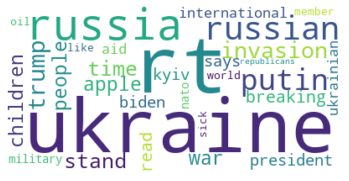

In [55]:
wordcloud = WordCloud(background_color='white', collocations=False, max_words=30).fit_words(freq_words)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()